# Separating FRBs from RFI

Adapted from the code published from ["Applying Deep Learning 
to Fast Radio Burst Classification"](https://arxiv.org/pdf/1803.03084.pdf) by Liam Connor and Joeri van Leeuwen, as
well as code wrapping done by Vishal Gajjar.

Trains a convolutional neural network to recognize differences between fast
radio bursts and RFI. Training is done by simulating a specified number of FRB
examples and injecting them into noisy backgrounds.

In [1]:
import sys, os
import numpy as np
from scipy.signal import gaussian, fftconvolve
from time import time
import h5py
import random
from tqdm import tqdm, trange  # progress bar
import argparse  # to parse arguments in command line
import tensorflow as tf
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt


# import psrchive as psr

tf.logging.set_verbosity(tf.logging.INFO)

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD
from keras.models import load_model

import bokeh
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource
from bokeh.models.ranges import Range1d, DataRange1d # used to flip axes for magnitude scale
from bokeh.palettes import Category10, Viridis256

output_notebook() # render bokeh plots within the notebook

Using TensorFlow backend.


Loading BokehJS ...

### Plotting functions

In [2]:
# setting matplotlib default font size
mpl.rcParams['font.size'] = 18

# setting bokeh colors
colors = Category10[5]
colors = {'blue': colors[0], 'orange': colors[1], 'green': colors[2], 'red': colors[3], 'purple': colors[4]}

# general function to create sweet, sweet Bokeh plots
def bokeh_plot(x, y, plot_type='scatter', title=None, x_label=None, y_label=None, height=500, width=900, 
               flipped_x=False, flipped_y=False, size=5, line_width=2, line_style='solid', x_axis_type='linear', y_axis_type='linear', 
               color='blue', line_alpha=0.8, fill_alpha=0.7, legend=None, show_plot=False):  
    
    plot = figure(title = title, x_axis_label = x_label, y_axis_label = y_label, 
                  x_axis_type = x_axis_type, y_axis_type = y_axis_type, plot_width = width, 
                  plot_height = height, x_range = DataRange1d(flipped = flipped_x), 
                  y_range = DataRange1d(flipped = flipped_y))
    
    if plot_type == 'scatter':
        plot.circle(x, y, size=size, line_alpha=0.8, fill_color=colors[color], 
                    line_color=colors[color], fill_alpha=fill_alpha, legend=legend)
    elif plot_type == 'line':
        plot.line(x, y, line_width=line_width, line_color=colors[color], line_dash=line_style, 
                  line_alpha=line_alpha, legend=legend)
    else:
        return "Not a valid plot type"
    
    if show_plot:
        show(plot)
        
    return plot

# plot a histogram in bokeh
def histogram(data, title=None, x_label=None, y_label=None, normed=False, bins=20, height=500, width=900, 
              color='blue', alpha=0.6, show_plot=False):
    
    plot = figure(title=title, x_axis_label=x_label, y_axis_label=y_label, plot_width=width, plot_height=height)
    
    # normalize that histogram yourself, because numpy can't do it
    if normed:
        hist, edges = np.histogram(data, bins=bins)
        hist = hist / np.sum(hist) * 100
    else:
        hist, edges = np.histogram(data, bins=bins)
        
    plot.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], color=colors[color], alpha=alpha)
    
    if show_plot:
        show(plot)
        
    return plot

In [43]:
class SimulatedFRB(object):
    """ Class to generate a realistic fast radio burst and 
    add the event to data, including scintillation and 
    temporal scattering. @source liamconnor
    """
    def __init__(self, shape=(64, 256), f_ref=1350, bandwidth=1500, max_width=4, tau=0.1):
        assert type(shape) == tuple and len(shape) == 2, "shape needs to be a tuple of 2 integers"        
        self.shape = shape

        # reference frequency (MHz) of observations
        self.f_ref = f_ref
        
        # maximum width of pulse, high point of uniform distribution for pulse width
        self.max_width = max_width 
        
        # number of bins/data points on the time (x) axis
        self.nt = shape[1] 
        
        # frequency range for the pulse, given the number of channels
        self.frequencies = np.linspace(f_ref - bandwidth // 2, f_ref + bandwidth // 2, shape[0])

        # where the pulse will be centered on the time (x) axis
        self.t0 = np.random.randint(-shape[1] + max_width, shape[1] - max_width) 

        # scattering timescale (milliseconds)
        self.tau = tau

        # randomly generated SNR and FRB generated after calling injectFRB()
        self.SNR = None
        self.FRB = None

        '''Simulates background noise similar to the .ar 
        files. Backgrounds will be injected with FRBs to 
        be used in classification later on.'''
        self.background = np.random.randn(*self.shape)

    def gaussian_profile(self):
        """Model pulse as a normalized Gaussian."""
        t = np.linspace(-self.nt // 2, self.nt // 2, self.nt)
        g = np.exp(-(t / np.random.randint(1, self.max_width))**2)
        
        if not np.all(g > 0):
            g += 1e-18

        # clone Gaussian into 2D array with NFREQ rows
        return np.tile(g, (self.shape[0], 1))
    
    def scatter_profile(self):
        """ Include exponential scattering profile."""
        tau_nu = self.tau * (self.frequencies / self.f_ref) ** -4
        t = np.linspace(0, self.nt//2, self.nt)

        prof = np.exp(-t / tau_nu.reshape(-1, 1)) / tau_nu.reshape(-1, 1)
        return prof / np.max(prof, axis=1).reshape(-1, 1)

    def pulse_profile(self):
        """ Convolve the gaussian and scattering profiles
        for final pulse shape at each frequency channel.
        """
        gaus_prof = self.gaussian_profile()
        scat_prof = self.scatter_profile()
        
        # convolve the two profiles for each frequency
        pulse_prof = np.array([fftconvolve(gaus_prof[i], scat_prof[i])[:self.nt] for i in np.arange(self.shape[0])])

        # normalize! high frequencies should have narrower pulses
        pulse_prof /= np.trapz(pulse_prof, axis=1).reshape(-1, 1)
        return pulse_prof

    def scintillate(self):
        """ Include spectral scintillation across the band.
        Approximate effect as a sinusoid, with a random phase
        and a random decorrelation bandwidth.
        """
        # Make location of peaks / troughs random
        scint_phi = np.random.rand()

        # Make number of scintils between 0 and 10 (ish)
        nscint = np.exp(np.random.uniform(np.log(1e-3), np.log(7)))

        if nscint < 1:
            nscint = 0

        envelope = np.cos(2 * np.pi * nscint * (self.frequencies / self.f_ref)**-2 + scint_phi)
        
        # set all negative elements to zero and add small factor
        envelope[envelope < 0] = 0
        envelope += 0.1

        # add scintillation to pulse profile
        pulse = self.pulse_profile()
        pulse *= envelope.reshape(-1, 1)
        self.FRB = pulse

    def roll(self):
        """Move FRB to random location of the time axis (in-place),
        ensuring that the shift does not cause one end of the FRB
        to end up on the other side of the array."""
        bin_shift = np.random.randint(low = -self.shape[1] // 2 + self.max_width,
                                      high = self.shape[1] // 2 - self.max_width)
        self.FRB = np.roll(self.FRB, bin_shift, axis=1)

    def fractional_bandwidth(self, frac_low=0.5, frac_high=0.9):
        """Cut some fraction of the full pulse out."""
        # Fraction of frequency (y) axis for the signal
        frac = np.random.uniform(frac_low, frac_high)
        nchan = self.shape[0]

        # collect random fraction of FRB and add to background
        stch = np.random.randint(0, nchan * (1 - frac))
        slice_freq = slice(stch, int(stch + (nchan * frac)))
        slice_FRB = np.copy(self.FRB[slice_freq])
        self.FRB[:, :] = 1e-18
        self.FRB[slice_freq] = slice_FRB

    def sample_SNR(self, SNRmin=8, SNR_sigma=1.0, SNRmax=30):
        """Sample peak SNR from log-normal distribution and throw
        out any value greater than SNRmax."""
        if SNRmin < 0:
            raise ValueError('Minimum SNR cannot be negative')
        if SNRmin > SNRmax:
            raise ValueError('SNRmin cannot be greater than SNRmax')

        random_SNR = SNRmin + np.random.lognormal(mean=1.0, sigma=SNR_sigma)
        if random_SNR < SNRmax:     
            self.SNR = random_SNR
            return random_SNR
        else:
            return self.sample_SNR(SNRmin, SNR_sigma, SNRmax)

    def injectFRB(self, SNR, background=None):
        """Inject the FRB into freq-time array of Gaussian noise"""
        if background is None:
            background = self.background

        # get 1D noise and multiply signal by given SNR
        noise_profile = np.mean(background, axis=0)
        peak_value = SNR * np.std(noise_profile)
        profile_FRB = np.mean(self.FRB, axis=0)
        
        # make a signal with given SNR
        signal = self.FRB * (peak_value / np.max(profile_FRB))
        return signal

    def simulateFRB(self, background=None, SNRmin=8, SNR_sigma=1.0, SNRmax=15):
        """Combine everything together and inject the FRB into a
        background array of Gaussian noise for the simulation. After
        this method works and is detected by the neural network, proceed
        to inject the FRB into the actual noise files given by psrchive."""
        if background is None:
            background = self.background

        # Create the FRB
        self.scintillate() # make the pulse profile with scintillation
        self.roll() # move the FRB around freq-time array
        self.fractional_bandwidth() # cut out some of the bandwidth
        self.sample_SNR(SNRmin, SNR_sigma, SNRmax) # get random SNR

        # add to the Gaussian noise
        self.simulatedFRB = background + self.injectFRB(background=background, SNR=self.SNR)

In [4]:
def make_labels(num_data, SNRmin, SNRmax=15):
    '''Simulates the background for num_data number of points and appends to ftdata.
    Each iteration will have just noise and an injected FRB, so the label list should
    be populated with just 0 and 1, which will then be shuffled later.'''

    ftdata = []
    labels = []
    values_SNR = []

    for sim in trange(num_data):
        # create simulation object and add FRB to it
        event = SimulatedFRB()
        event.simulateFRB(background=None, SNRmin=SNRmin, SNR_sigma=1.0, SNRmax=SNRmax)
        
        # put simulated data into ftdata and label it RFI
        ftdata.append(event.background)
        labels.append(0)

        # inject FRB into data and label it true sighting
        ftdata.append(event.simulatedFRB)
        labels.append(1)
        values_SNR.extend([event.SNR, event.SNR])

    return np.array(ftdata), np.array(labels), np.array(values_SNR)

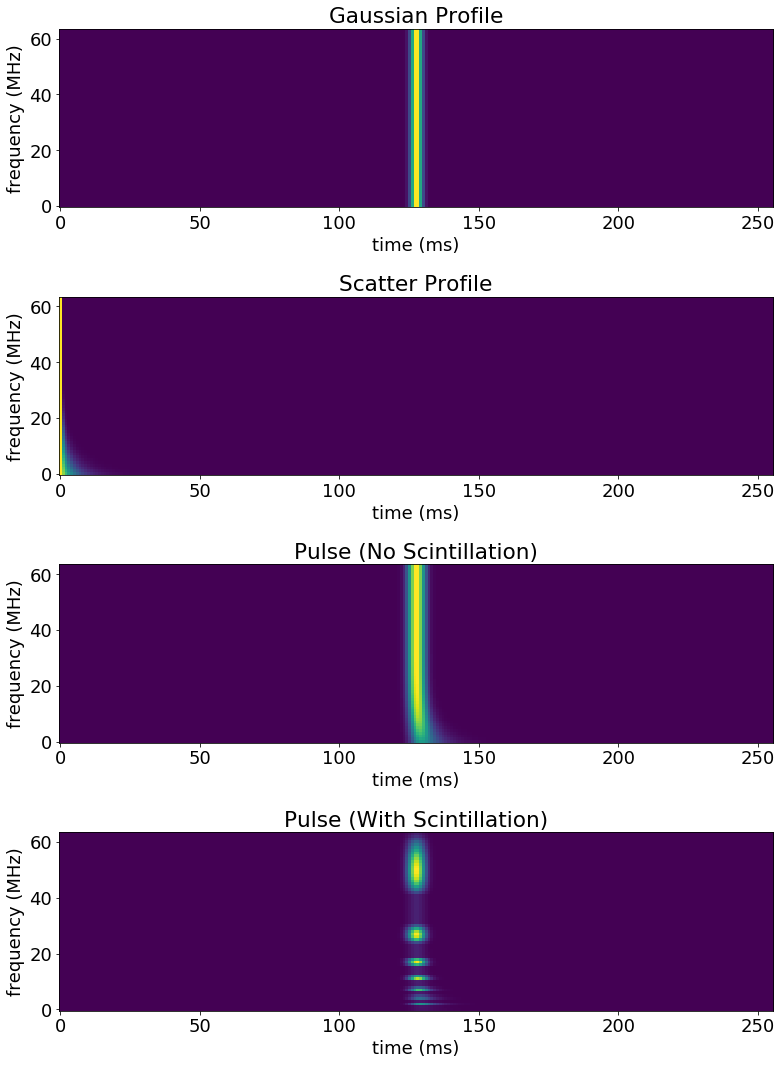

In [44]:
np.random.seed(175)
event = SimulatedFRB()
event.scintillate()

profiles = {'Gaussian Profile': event.gaussian_profile(),
            'Scatter Profile': event.scatter_profile(),
            'Pulse (No Scintillation)': event.pulse_profile(),
            'Pulse (With Scintillation)': np.copy(event.FRB)}

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 15))
for ax, profile in zip(axes, profiles.keys()):
    ax.imshow(profiles[profile], origin='lower')
    ax.set(title=profile, xlabel='time (ms)', ylabel='frequency (MHz)')

fig.tight_layout()
fig.subplots_adjust(hspace=0.5)

In [42]:
fig.savefig('ones_FRB.png', dpi=300)

In [39]:
def plot_simulation_steps(prof_name):
    np.random.seed(175)
    event = SimulatedFRB()
    event.scintillate()

    profiles = {'Gaussian Profile': event.gaussian_profile(),
                'Scatter Profile': event.scatter_profile(),
                'Pulse (No Scintillation)': event.pulse_profile(),
                'Pulse (With Scintillation)': np.copy(event.FRB)}
    
    # plot the simulation steps depending on selected profile
    fig_prof, ax_prof = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
    freq_extent = [0, event.nt, event.frequencies[0], event.frequencies[-1]]

    # plotting the data (frequency-time) array
    ax_prof[0].imshow(profiles[prof_name], origin='lower', extent=freq_extent, aspect='auto')
    ax_prof[0].set(title=prof_name, xlabel='time (ms)', ylabel='frequency (MHz)')

    # plot 1D profile from the top, middle, and bottom of the array
    ax_prof[1].plot(profiles[prof_name][0], linewidth=2, label=f'{int(event.frequencies[0])} MHz')
    ax_prof[1].plot(profiles[prof_name][len(profile) // 2], linewidth=2,
                 label=f'{int(event.frequencies[len(event.frequencies) // 2])} MHz')
    ax_prof[1].plot(profiles[prof_name][-1], linewidth=2, label=f'{int(event.frequencies[-1])} MHz')
    ax_prof[1].set(title=f"1D {prof_name}", xlabel='time (ms)', ylabel='flux (W/m²)')

    # give it a legend
    ax_prof[1].legend()

    # make plot spacing all nice
    fig_prof.tight_layout()
    fig_prof.subplots_adjust(hspace=0.5)
    
    return fig_prof

In [62]:
np.random.seed(63)

# create simulation objects and simulate an FRB for each of them
simulated_events = [SimulatedFRB() for i in np.arange(8)]
for event in simulated_events:
    event.simulateFRB(SNRmin=6, SNRmax=20)

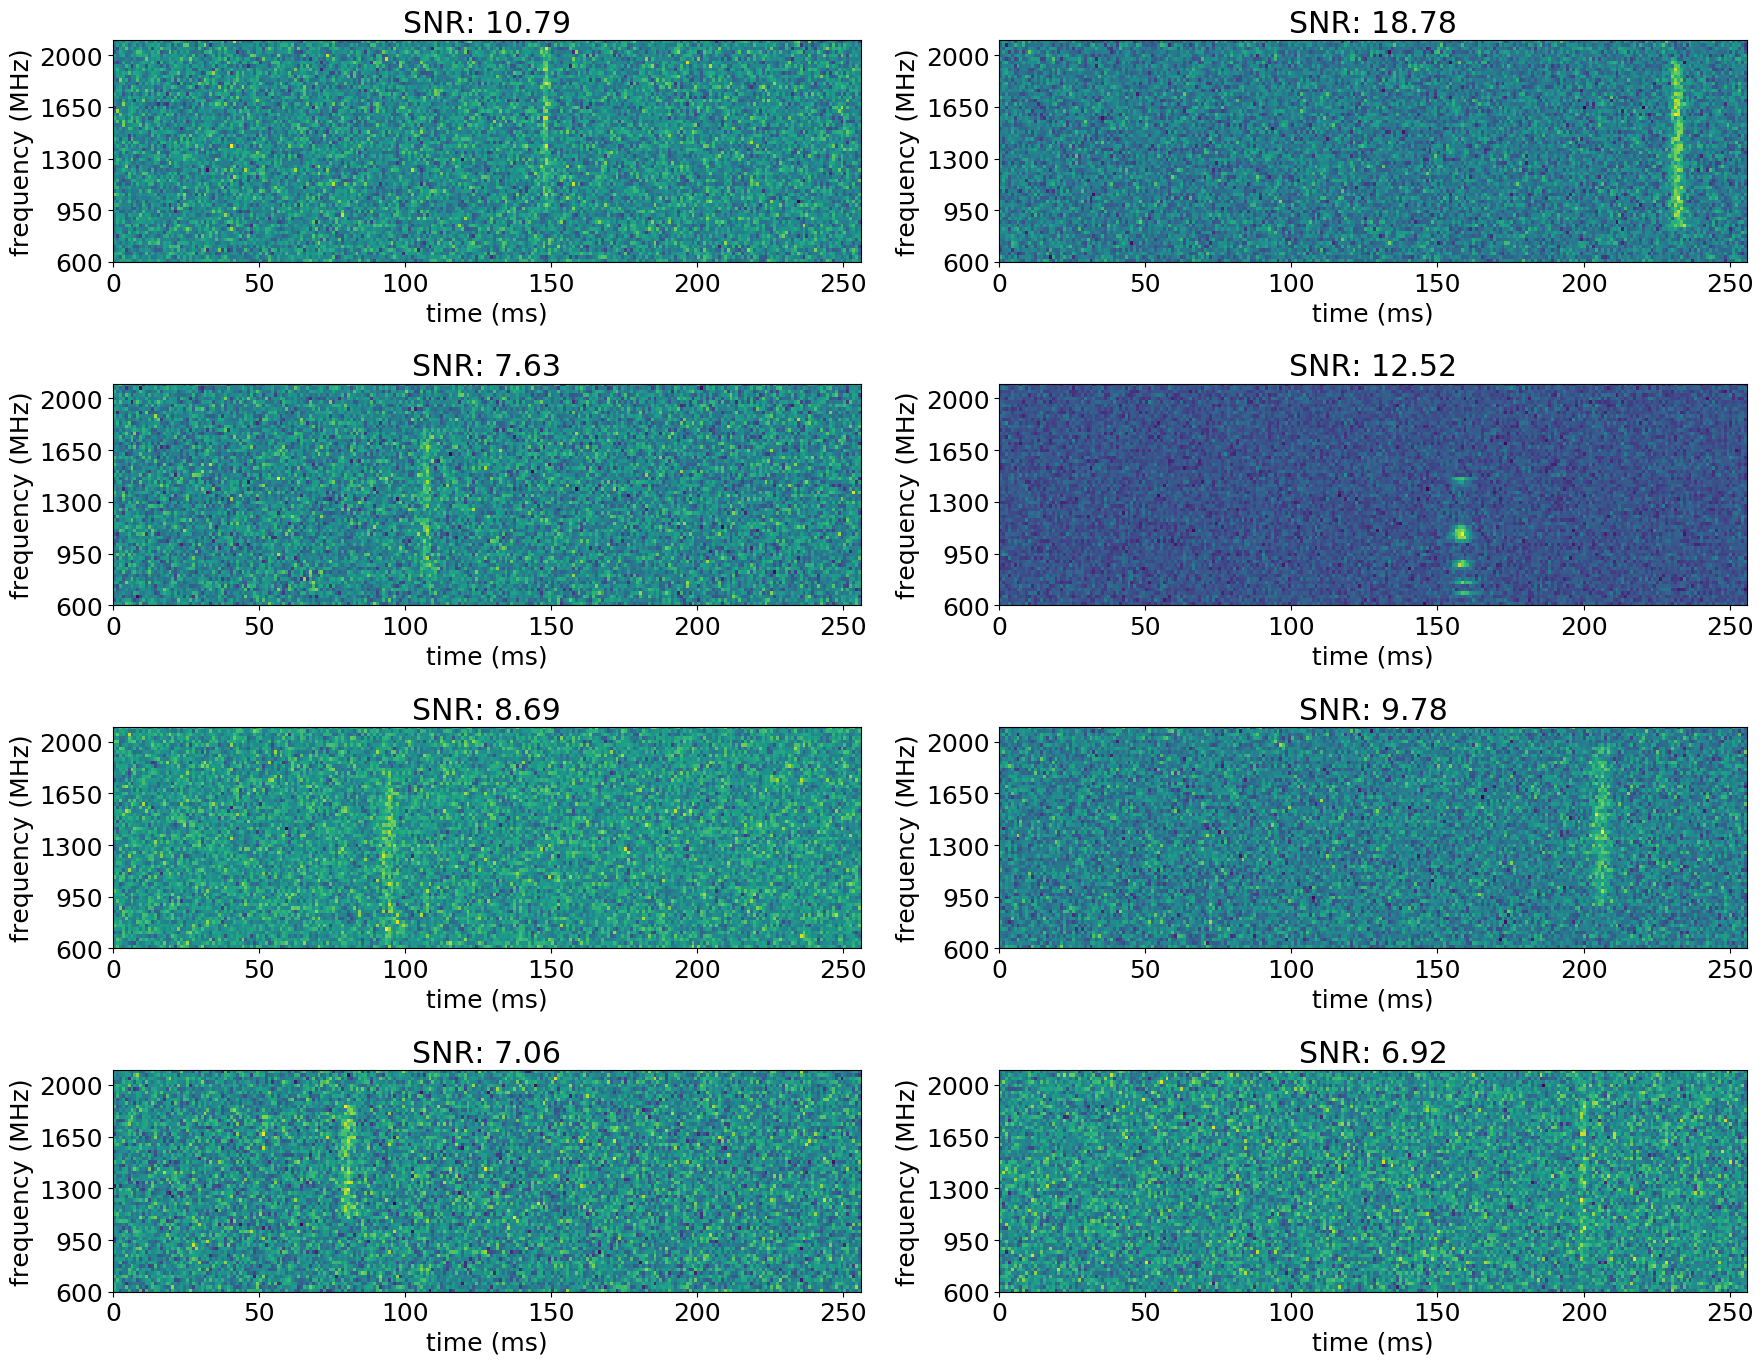

In [492]:
# plot the simulated events
fig_simulated, ax_simulated = plt.subplots(nrows=4, ncols=2, figsize=(18, 14))

for axis, event in zip(ax_simulated.flatten(), simulated_events):
    axis.imshow(event.simulatedFRB, extent=[0, event.nt, event.frequencies[0], event.frequencies[-1]],
                origin='lower', aspect='auto')
    axis.set(title=f"SNR: {np.round(event.SNR, 2)}", xlabel='time (ms)', ylabel='frequency (MHz)')
    axis.set_yticks(np.arange(event.frequencies[0], event.frequencies[-1], 350))

fig_simulated.tight_layout()

## Defining the Convolutional Neural Network

In [471]:
def construct_conv2d(train_data, train_labels, eval_data, eval_labels, 
                     nfreq=64, ntime=256, epochs=32, nfilt1=32, nfilt2=64,
                     batch_size=32, saved_model_name='best_model.h5'):
    """ Build a two-dimensional convolutional neural network
    with a binary classifier. Can be used for, e.g.,
    freq-time dynamic spectra of pulsars, dm-time intensity array.

    Parameters:
    ----------
    train_data : ndarray
        (ntrain, ntime, 1) float64 array with training data
    train_labels :  ndarray
        (ntrigger, 2) binary labels of training data [0, 1] = FRB, [1, 0]=RFI 
    eval_data : ndarray
        (neval, ntime, 1) float64 array with evaluation data
    eval_labels : 
        (neval, 2) binary labels of eval data 
    epochs : int 
        Number of training epochs 
    nfilt1 : int
        Number of neurons in first hidden layer 
    nfilt2 : int 
        Number of neurons in second hidden layer 
    batch_size : int 
        Number of batches for training   
       
    Returns
    -------
    model : Keras model
        Fitted model

    score : np.float 
        Accuracy, the fraction of predictions that are correct 

    """
    # number of elements for each axis
    nfreq, ntime = train_data.shape[1:3]

    model = Sequential()

    # create nfilt1 convolution filters, each of size 5x5
    # max pool and randomly drop some fraction of nodes to limit overfitting
    model.add(Conv2D(nfilt1, (3, 3), activation='relu', input_shape=(nfreq, ntime, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # second convolutional layer
    model.add(Conv2D(nfilt2, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # flatten all neurons and run through fully connected layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    # output probabilities of predictions and choose the maximum
    model.add(Dense(2, activation='softmax'))

    # optimize using stochastic gradient descent
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

    print("Using batch_size: %d" % batch_size)
    print("Using %d epochs" % epochs)

    # save best model according to validation accuracy
    best_model_cb = keras.callbacks.ModelCheckpoint(f"{saved_model_name}", monitor='val_acc', verbose=1,
                                                    save_best_only=True)

    model.fit(train_data, train_labels, validation_data=(eval_data, eval_labels),
              batch_size=batch_size, epochs=epochs, callbacks=[best_model_cb])

    score = model.evaluate(eval_data, eval_labels, batch_size=batch_size)
    print(score)

    return model, score

In [366]:
model = Sequential()

# create nfilt1 convolution filters, each of size 5x5
# max pool and randomly drop some fraction of nodes to limit overfitting
model.add(Conv2D(32, (2, 2), activation='relu', input_shape=(64, 256, 1)))
# model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# second convolutional layer with 64 filters
model.add(Conv2D(64, (2, 2), activation='relu'))
# model.add(Conv2D(64, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# flatten all neurons
model.add(Flatten())

# run through fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

# run through fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# output probabilities of predictions and choose the maximum
model.add(Dense(2, activation='softmax'))

In [367]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_443 (Conv2D)          (None, 63, 255, 32)       160       
_________________________________________________________________
max_pooling2d_242 (MaxPoolin (None, 31, 127, 32)       0         
_________________________________________________________________
conv2d_444 (Conv2D)          (None, 30, 126, 64)       8256      
_________________________________________________________________
max_pooling2d_243 (MaxPoolin (None, 15, 63, 64)        0         
_________________________________________________________________
dropout_232 (Dropout)        (None, 15, 63, 64)        0         
_________________________________________________________________
flatten_110 (Flatten)        (None, 60480)             0         
_________________________________________________________________
dense_336 (Dense)            (None, 128)               7741568   
__________

In [298]:
def get_classification_results(y_true, y_pred, test_SNR=None):
    """ Take true labels (y_true) and model-predicted 
    label (y_pred) for a binary classifier, and return 
    true_positives, false_positives, true_negatives, false_negatives
    """
    true_positives = np.where((y_true == 1) & (y_pred == 1))[0]
    false_positives = np.where((y_true == 0) & (y_pred == 1))[0]
    true_negatives = np.where((y_true == 0) & (y_pred == 0))[0]
    false_negatives = np.where((y_true == 1) & (y_pred == 0))[0]
    
    return true_positives, false_positives, true_negatives, false_negatives

def confusion_mat(y_true, y_pred):
    """ Generate a confusion matrix for a
    binary classifier based on true labels (
    y_true) and model-predicted label (y_pred)

    returns np.array([[TP, FP],[FN, TN]])
    """
    TP, FP, TN, FN = get_classification_results(y_true, y_pred)

    NTP = len(TP)
    NFP = len(FP)
    NTN = len(TN)
    NFN = len(FN)

    conf_mat = np.array([[NTP, NFP], [NFN, NTN]])
    return conf_mat

def print_metric(y_true, y_pred):
    """ Take true labels (y_true) and model-predicted 
    label (y_pred) for a binary classifier
    and print a confusion matrix, metrics, 
    return accuracy, precision, recall, fscore
    """
    conf_mat = confusion_mat(y_true, y_pred)

    NTP, NFP, NTN, NFN = conf_mat[0, 0], conf_mat[0, 1], conf_mat[1, 1], conf_mat[1, 0]

    print("Confusion matrix:")

    print('\n'.join([''.join(['{:8}'.format(item) for item in row])
                     for row in conf_mat]))

    accuracy = (NTP + NTN) / conf_mat.sum()
    precision = NTP / (NTP + NFP + 1e-19) # prevent division by zero
    recall = NTP / (NTP + NFN + 1e-19)
    fscore = 2 * precision * recall / (precision + recall)

    print("accuracy: %f" % accuracy)
    print("precision: %f" % precision)
    print("recall: %f" % recall)
    print("fscore: %f" % fscore)

    return accuracy, precision, recall, fscore

In [235]:
N_train = 1000
start = time()
ftdata, labels, SNR = make_labels(N_train, SNRmin=8, SNRmax=9)
print(f"Generating {N_train} examples took {time() - start} seconds")

100%|██████████| 1000/1000 [00:06<00:00, 164.47it/s]


Generating 1000 examples took 6.285831928253174 seconds


In [299]:
def confusion_matrix_per_SNR(model, num_samples, SNR_range):
    """Predict a model based on a given range of SNRs and
    return metrics summarizing the model performance.
    
    Parameters:
    ----------
    model : Keras model
        Model to predict with. Must be compiled!
    num_samples : int
        Number of freq-time arrays to generate and predict
    SNR_range : ndarray 
        (2,) Array of two elements consisting of SNRmin and SNRmax
        for the range of the SNRs to be predicted
    
    Returns
    -------
    accuracy : float
        Fraction of predictions that are correct)
    precision : float
        True positives to number of all predicted to be positive
    recall : float
        Fraction of correctly classified positives to true positives
    fscore : np.float 
        Harmonic mean of precision and sensitivity, a "balance" between the two
    """
    SNRmin, SNRmax = SNR_range
    test_set, test_labels, test_SNR = make_labels(num_samples, SNRmin=SNRmin, SNRmax=SNRmax)
    
    # make predictions with the model
    start = time()
    predictions = model.predict_classes(test_set[..., None])
    print(f"Predicting {num_samples} samples took {time() - start} seconds")
    
    return test_set, confusion_mat(test_labels, predictions)

In [404]:
model = load_model('SNRmin4.h5')
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [405]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 63, 255, 32)       160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 127, 32)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 127, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 126, 64)       8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 63, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 63, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 60480)             0         
__________

In [401]:
NTP + NTN

1998

In [406]:
SNR_range = np.array([0, 1])
full_test_set = []
num_incorrect, num_missed_FRBs = [], []
accuracies, precisions, recalls, fscores = [], [], [], []

while SNR_range[1] <= 15:
    test_SNR_range, conf_mat = confusion_matrix_per_SNR(model, 1000, SNR_range)
    NTP, NFP, NTN, NFN = conf_mat[0, 0], conf_mat[0, 1], conf_mat[1, 1], conf_mat[1, 0]
        
    accuracy = (NTP + NTN) / conf_mat.sum()
    precision = NTP / (NTP + NFP)
    recall = NTP / (NTP + NFN)
    fscore = 2 * precision * recall / (precision + recall)
    
    # add current test set to the full list
    full_test_set.append(test_SNR_range)
    
    # append number of incorrect results for each SNR bin
    num_incorrect.append(NFP + NFN)
    num_missed_FRBs.append(NFN)
    
    # append metrics to list for each SNR bin
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    fscores.append(fscore)
    
    SNR_range += 1

  1%|          | 7/1000 [00:00<00:14, 67.32it/s]

Predicting 1000 samples took 12.358382940292358 seconds


  1%|          | 9/1000 [00:00<00:11, 85.83it/s]

Predicting 1000 samples took 4.61778998374939 seconds


  1%|          | 8/1000 [00:00<00:13, 74.52it/s]

Predicting 1000 samples took 5.860105991363525 seconds


  1%|          | 9/1000 [00:00<00:11, 85.46it/s]

Predicting 1000 samples took 5.007525682449341 seconds


  1%|          | 7/1000 [00:00<00:15, 62.62it/s]

Predicting 1000 samples took 5.476923704147339 seconds


  1%|          | 8/1000 [00:00<00:13, 71.11it/s]

Predicting 1000 samples took 4.8403472900390625 seconds


  1%|          | 7/1000 [00:00<00:14, 69.03it/s]

Predicting 1000 samples took 4.844932794570923 seconds


  1%|          | 8/1000 [00:00<00:13, 72.27it/s]

Predicting 1000 samples took 5.918693780899048 seconds


  1%|          | 9/1000 [00:00<00:11, 89.23it/s]

Predicting 1000 samples took 4.301781892776489 seconds


  1%|          | 9/1000 [00:00<00:11, 87.39it/s]

Predicting 1000 samples took 4.565115928649902 seconds


  1%|          | 9/1000 [00:00<00:11, 89.29it/s]

Predicting 1000 samples took 4.107574939727783 seconds


  1%|          | 10/1000 [00:00<00:09, 99.85it/s]

Predicting 1000 samples took 4.1980202198028564 seconds


  1%|          | 10/1000 [00:00<00:10, 95.41it/s]

Predicting 1000 samples took 4.255955934524536 seconds


  1%|          | 9/1000 [00:00<00:11, 85.55it/s]

Predicting 1000 samples took 4.115092992782593 seconds


100%|██████████| 1000/1000 [00:14<00:00, 71.29it/s]


Predicting 1000 samples took 5.82184910774231 seconds


In [407]:
recovery_plot = figure(title='Neural Network Recall', x_axis_label='SNR', y_axis_label='percentage (%)',
                      y_range=(-0.01, 1.01), width=800)
recovery_plot.vbar(x=np.arange(1, 16), top=np.array(num_missed_FRBs) / 1000, width=0.8, 
                   alpha=0.85, legend='Missed FRBs')
recovery_plot.line(np.arange(1, 16), recalls, line_width=2, color=colors['orange'], 
                   line_alpha=0.8, legend='Recall Rate')
recovery_plot.legend.location = "top_right"

recovery_plot.title.text_font_size = '18pt'
recovery_plot.xaxis.axis_label_text_font_size = "16pt"
recovery_plot.yaxis.axis_label_text_font_size = "16pt"
recovery_plot.legend.label_text_font_size = "14pt"

show(recovery_plot)

In [409]:
accuracy_plot = figure(title='Neural Network Accuracy', x_axis_label='SNR', y_axis_label='percentage (%)',
                      y_range=(-0.01, 1.01), width=800)
accuracy_plot.vbar(x=np.arange(1, 16), top=np.array(num_incorrect) / 2000, width=0.8, 
                   alpha=0.85, legend='Incorrect Predictions')
accuracy_plot.line(np.arange(1, 16), accuracies, line_width=2, color=colors['orange'], 
                   line_alpha=0.8, legend='Accuracy Rate')
accuracy_plot.legend.location = "top_right"

accuracy_plot.title.text_font_size = '18pt'
accuracy_plot.xaxis.axis_label_text_font_size = "16pt"
accuracy_plot.yaxis.axis_label_text_font_size = "16pt"
accuracy_plot.legend.label_text_font_size = "14pt"

show(accuracy_plot)

In [389]:
num_incorrect

[999, 984, 828, 528, 235, 71, 16, 9, 4, 4, 8, 4, 6, 5, 2]

In [390]:
num_missed_FRBs

[996, 981, 826, 524, 230, 65, 16, 3, 0, 0, 0, 0, 0, 0, 0]

In [391]:
accuracies

[0.5005,
 0.508,
 0.586,
 0.736,
 0.8825,
 0.9645,
 0.992,
 0.9955,
 0.998,
 0.998,
 0.996,
 0.998,
 0.997,
 0.9975,
 0.999]

In [403]:
recovery_plot.output_backend = "svg"
bokeh.io.export_svgs(recovery_plot, "worse_recall.svg")

MaxRetryError: HTTPConnectionPool(host='127.0.0.1', port=63419): Max retries exceeded with url: /wd/hub/session/7fa7db60-69f2-11e9-b238-c7eb8960168f/url (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x1eb43b8d0>: Failed to establish a new connection: [Errno 61] Connection refused'))

In [ ]:
start = time()
ftdata, labels, SNR = make_labels(N_train, SNRmin=2, SNRmax=3)
print(f"Generating {N_train} examples took {time() - start} seconds")

In [39]:
def predict_from_model(model_path, test_set):
    """
    Loads in a model and uses it to predict whether 
    a given set of FRBs are real or RFI.

    Parameters:
    ----------
    model_path : str 
        File path to model
    test_set : ndarray
        (num_test, freq, time) array consisting of test set
        that will be transformed and predicted by the model
       
    Returns
    -------
    predictions : ndarray
        A 1-D array of 0s and 1s, where 0 --> RFI and 1 --> FRB 
    """
    model = load_model(model_path)
    
    # compile model
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    # predict from test set
    predictions = model.predict_classes(test_set[..., None])
    return predictions

In [248]:
def normalize_data(ftdata):
    # dshape = ftdata.shape
    # subtract median of each column and divide by SD
    # ftdata = ftdata.reshape(len(ftdata), -1)
    normalized_ftdata = np.copy(ftdata)
    normalized_ftdata -= np.median(ftdata, axis=1)[:, None]
    normalized_ftdata /= np.std(ftdata, axis=1)[:, None]
    
    # zero out nans
    normalized_ftdata[normalized_ftdata != normalized_ftdata] = 0.0
    #ftdata = ftdata.reshape(dshape)
    
    return normalized_ftdata

In [246]:
def real_normalize_data(ftdata):
    ftdata -= np.median(ftdata, axis=1)
    ftdata /= np.std(ftdata, axis=1)

    return ftdata

In [247]:
normed = normalize_data(ftdata)

ValueError: operands could not be broadcast together with shapes (2000,64,256) (2000,1,64) (2000,64,256) 

In [237]:
len(SNR)

2000

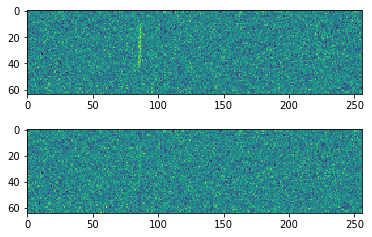

In [244]:
index = 19

fig, ax = plt.subplots(nrows=2)
ax[0].imshow(ftdata[index])
ax[1].imshow(normed[index])

In [222]:
np.allclose(ftdata[11], normed[11])

True

In [197]:
NTRAIN = int(len(label) * 0.5)

ind = np.arange(Nfl)
np.random.shuffle(ind)

# split indices into training and evaluation set
ind_train = ind[:NTRAIN]
ind_eval = ind[NTRAIN:]

train_data_freq, eval_data_freq = ftdata[ind_train], ftdata[ind_eval]

train_labels, eval_labels = label[ind_train], label[ind_eval]

# convert to binary matrix
train_labels_keras = keras.utils.to_categorical(train_labels)
eval_labels_keras = keras.utils.to_categorical(eval_labels)

ValueError: operands could not be broadcast together with shapes (2000,64,256) (2000,256) (2000,64,256) 

In [432]:
least_probable = np.load('classification_results.npy')

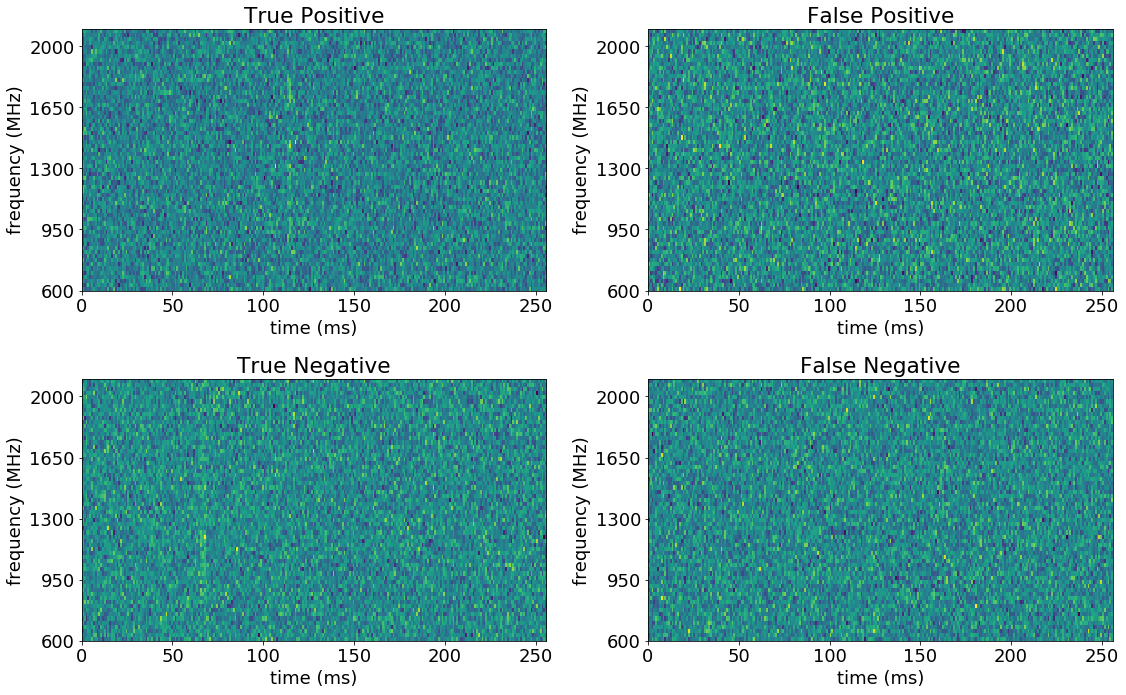

In [438]:
fig_confusion, ax_confusion = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
confmat_titles = ['True Positive', 'False Positive', 'True Negative', 'False Negative']

for image, ax, title in zip(least_probable, ax_confusion.flatten(), confmat_titles):
    ax.imshow(image, extent=[0, event.nt, event.frequencies[0], event.frequencies[-1]],
              origin='lower', aspect='auto')
    ax.set(title=title, xlabel='time (ms)', ylabel='frequency (MHz)')
    ax.set_yticks(np.arange(event.frequencies[0], event.frequencies[-1], 350))

fig_confusion.tight_layout()

In [5]:
real_RFI = np.load('psr_arrays.npy')
real_RFI.shape

(320, 64, 256)

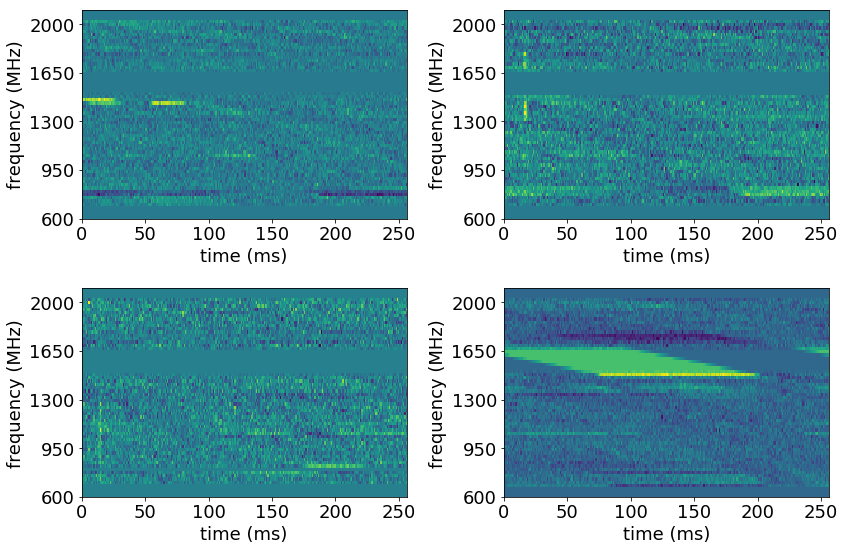

In [8]:
np.random.seed(25)
sample_RFI = real_RFI[np.random.randint(low=0, high=320, size=4)]

fig_RFI, ax_RFI = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for RFI_image, ax in zip(sample_RFI, ax_RFI.flatten()):
    ax.imshow(RFI_image, extent=[0, event.nt, event.frequencies[0], event.frequencies[-1]],
              origin='lower', aspect='auto')
    ax.set(xlabel='time (ms)', ylabel='frequency (MHz)')
    ax.set_yticks(np.arange(event.frequencies[0], event.frequencies[-1], 350))

fig_RFI.tight_layout()

In [22]:
event = SimulatedFRB()

In [452]:
recalls

[0.011,
 0.052,
 0.239,
 0.578,
 0.813,
 0.953,
 0.988,
 0.998,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [451]:
SNR_range

array([15, 16])

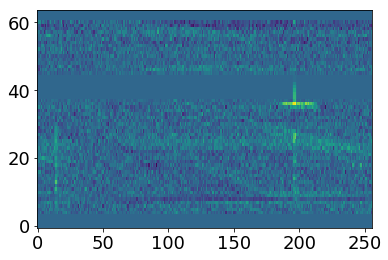

In [38]:
event.simulateFRB(background=real_RFI[0])
plt.imshow(event.simulatedFRB, origin='lower', aspect='auto')
plt.savefig('FRB_in_RFI.png', dpi=300)